# Učinkovitost oklapanja

Učinkovitost oklapanja $S$ računa se prema $S=A+R+B~\mathrm{[dB]}$, gdje je $A$ gubitak apsorpcije, $R$ je gubitak refleksije i $B$ je korekcijski faktor za tanke oklope (on se zanemaruje ako je $A\geq9~\mathrm{dB}$).

U nastavku je tablica materijala (Ott pp. 243), pa se po potrebi može dopuniti program.
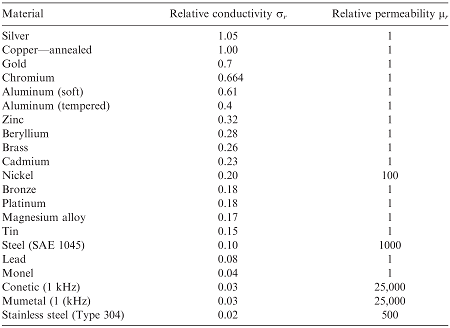

Pri izračunu nije uzeta u obzir frekvencijska ovisnost permeabilnosti materijala!

Granica između bliskog i dalekog polja je $\lambda/2\pi$. Za zadanu udaljenost od izvora $r$, frekvencija koja predstavlja granicu između bliskog i dalekog polja iznosi $r = \lambda/2\pi \rightarrow f_0 = \mathrm{c}/2\pi r$. Za frekvencije niže od $f_0$ izračun učinkovitosti oklapanja temelji se na izrazima za blisko polje, a za frekvencije više od $f_0$ izračun se temelji na izrazma za daleko polje.

In [1]:
materials = {'silver':'1.05,1', 'copper':'1,1', 'gold':'0.7,1', 'aluminum (soft)':'0.4,1', 'steel':'0.1,1000', 'stainless_steel':'0.02,500', 'mumetal_1kHz':'0.03,25000'} # name, sigma_r, mu_r

## Daleko polje

Izračun apsorpcijskih gubitaka $A$ za daleko polje računa se prema,
$A = 0.13t\sqrt{f\mu_r \sigma_r}~[\mathrm{dB}]$, gdje je $t$ debljina oklopa u [mm], $f$ je frekvencija u [Hz], a $\mu_r$ i $\sigma_r$ su relativna permeabilnost i permitivnost materijala. Vidi se da apsorpcijski gubitci rastu s korijenom frekvencije i s debljinom oklopa. Ako se debljina oklopa poveća dva puta također će se povećati apsorpcijski gubitci dva puta (u decibelima). Apsorpcijski gubitci su jednaki i za blisko magnetsko i blisko električno polje.

Izračun refleksijskih gubitaka $R$ računa se,
$R = 168 + 10\log(\sigma_r/(\mu_r f))~[\mathrm{dB}]$

Za daleko polje korekcijski faktor $B$ jednak je 0.

In [2]:
def far_A_R_B(t_mm,mu_r,sigma_r,f):    
    t_in = t_mm/25.4
    A = 3.34*t_in*np.sqrt(mu_r*sigma_r*f) # Ott eq. 6-13 
    R = 168 + 10*np.log10(sigma_r/(mu_r*f)) # Ott eq. 6-23b
    B = 0*f
    return A, R, B

## Blisko magnetsko polje

Izračun apsorpcijskih gubitaka $A$ za blisko magnetsko polje računa se prema $A = 0.13t\sqrt{f\mu_r \sigma_r}~[\mathrm{dB}]$.

Refleksijski gubitci za blisko magnetsko polje računaju se prema,
$R = 14.6 + 10\log{(\frac{\sigma_r f r^2}{\mu_r})}~[\mathrm{dB}]$. Ukoliko je udaljenost od izvora $r$ veća od $\lambda/2\pi$, tada se refleksijski gubitci računaju prema izrazu za daleko polje.

Za tanke oklope se računa i korekcijski faktor $B$ koji je jednak $B=20\log(1-e^{-2t/\delta})~[\mathrm{dB}]$.

In [3]:
def nearH_A_R_B(t_mm,mu_r,sigma_r,f,r):    
    t_in = t_mm/25.4
    A = 3.34*t_in*np.sqrt(mu_r*sigma_r*f) # Ott eq. 6-13 
    
    R = []
    for i in range(len(f)):
        lam=3e8/f[i]
        if (r < lam/(2*np.pi)):
            temp = 14.6 + 10*np.log10((sigma_r*f[i]*r**2)/mu_r) # Ott eq. 6-29b
            if (temp < 0):
                R.append(0)
            else:
                R.append(temp)
        else:
            R.append(168 + 10*np.log10(sigma_r/(mu_r*f[i]))) # Ott eq. 6-23b          
    
    if (A.any() >= 9):
        B = 0*f    
    else:
        delta_in = 2.6/(np.sqrt(mu_r*sigma_r*f))
        B = 20*np.log10(1-np.exp(-2*t_in/delta_in))
                
    return A, R, B

## Blisko električno polje

Izračun apsorpcijskih gubitaka $A$ za blisko električno polje računa se prema $A = 0.13t\sqrt{f\mu_r \sigma_r}~[\mathrm{dB}]$.

Refleksijski gubitci za blisko električno polje računaju se prema,  $R=322+10\log(\frac{\sigma_r}{\mu_r f^3 r^2})~[\mathrm{dB}]$. Ukoliko je udaljenost od izvora $r$ veća od $\lambda/2\pi$, tada se refleksijski gubitci računaju prema izrazu za daleko polje.

Za blisko električno polje korekcijski faktor $B$ jednak je 0.

In [4]:
def nearE_A_R_B(t_mm,mu_r,sigma_r,f,r):    
    t_in = t_mm/25.4
    A = 3.34*t_in*np.sqrt(mu_r*sigma_r*f) # Ott eq. 6-13 
        
    R = []    
    for i in range(len(f)):
        lam=3e8/f[i]
        if (r < lam/(2*np.pi)):
            temp = 322 + 10*np.log10(sigma_r/(mu_r*f[i]**3*r**2)) # Ott eq. 6-26b
            if (temp < 0):
                R.append(0)
            else:
                R.append(temp)
        else:
            R.append(168 + 10*np.log10(sigma_r/(mu_r*f[i]))) # Ott eq. 6-23b
            
    B = 0*f
    return A, R, B 

<IPython.core.display.Javascript object>


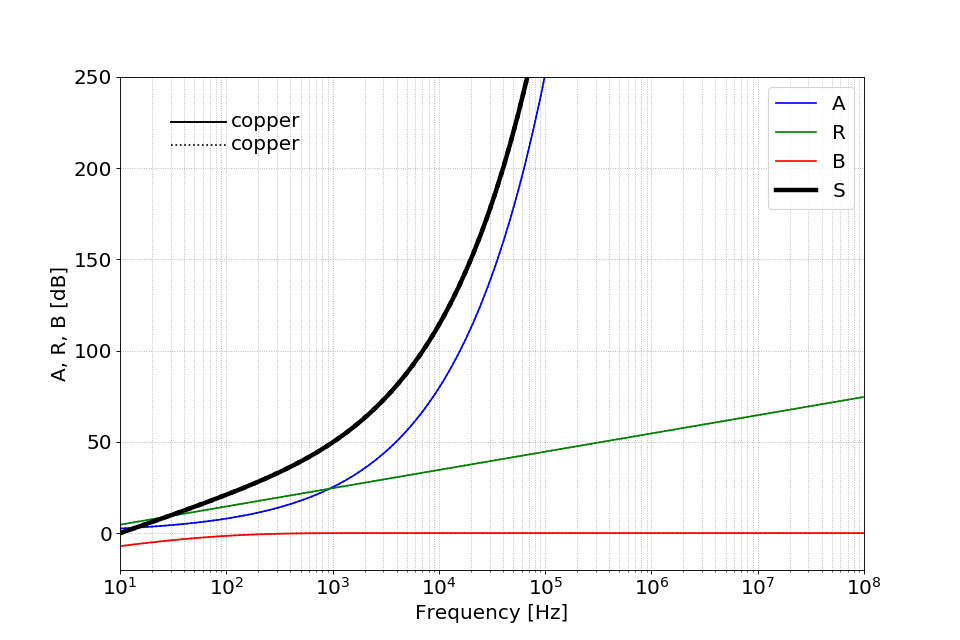

In [11]:
%matplotlib notebook
from ipywidgets import widgets
import numpy as np
import matplotlib.pyplot as plt

output = widgets.Output()

style = {'description_width': '150px'}
fmin = widgets.FloatLogSlider(min=1, max=4, step=1, value=10,description='$f_{min}$ [Hz]:',style=style,layout=widgets.Layout(width='75%'), continuous_update=False)
fmax = widgets.FloatLogSlider(min=5, max=10, step=1, value=1e8,description='$f_{max}$ [Hz]:',style=style,layout=widgets.Layout(width='75%'), continuous_update=False)
ymin = widgets.FloatSlider(min=-100,max=90, step=10, value=-20,description='plot $y_{min}$:',readout_format='.4f',style=style,layout=widgets.Layout(width='75%'), continuous_update=False)
ymax = widgets.FloatSlider(min=100,max=300, step=10, value=250,description='plot $y_{max}$:',readout_format='.1f',style=style,layout=widgets.Layout(width='75%'), continuous_update=False)

s_t = widgets.FloatSlider(value=1,min=0.01,max=10.0,step=0.01,description='thickness [mm]:',readout_format='.2f',style=style,layout=widgets.Layout(width='75%'), continuous_update=False)
s_r = widgets.FloatLogSlider(value=1,min=-1,max=8,step=0.1,description='source distance [m]:',readout_format='.1f',style=style,layout=widgets.Layout(width='75%'), continuous_update=False)
s_m1 = widgets.Dropdown(options=list(materials.keys()),value='silver',description='material no. 1:',style=style,layout=widgets.Layout(width='50%'))
s_m2 = widgets.Dropdown(options=list(materials.keys()),value='steel',description='material no. 2:',style=style,layout=widgets.Layout(width='50%'))
s_field = widgets.Dropdown(options=['near H', 'near E'],value='near H',description='field:',dstyle=style,layout=widgets.Layout(width='50%'))

s_sl = widgets.Checkbox(value=True, description='S',disabled=False,layout=widgets.Layout(width='20%'))
s_al = widgets.Checkbox(value=False, description='A',disabled=False,layout=widgets.Layout(width='20%'))
s_rl = widgets.Checkbox(value=False, description='R',disabled=False,layout=widgets.Layout(width='20%'))
s_bl = widgets.Checkbox(value=False, description='B',disabled=False,layout=widgets.Layout(width='20%'))

bhist = widgets.ToggleButtons(options=['OFF', 'ON'], description='History:',disabled=False,button_style='',style=style,layout=widgets.Layout(width='75%'), continuous_update=False)

fig = plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')     
plt.rcParams.update({'font.size': 18})  
axes = plt.gca()    
    
axes.set_xscale("log")
axes.set_yscale("linear")

plt.grid(True,which="both",ls=":")
plt.xlabel('Frequency [Hz]')
plt.ylabel('A, R, B [dB]')

ann_list = []
line_list = []
legend_list = []

def f1(fmin, fmax, ymin, ymax, t_mm, r_m, m1, m2, field, hst, sx, ax, rx, bx):
    
    f = np.logspace(np.log10(fmin), np.log10(fmax), num=100)
        
    sigma_r_1 = float(materials[m1].split(',')[0])
    mu_r_1 = float(materials[m1].split(',')[1])
    
    sigma_r_2 = float(materials[m2].split(',')[0])
    mu_r_2 = float(materials[m2].split(',')[1])       
    
    #if (field == 'far'):
    #    A_1,R_1,B_1 = far_A_R_B(t_mm,mu_r_1,sigma_r_1,f)  
    #    A_2,R_2,B_2 = far_A_R_B(t_mm,mu_r_2,sigma_r_2,f)  
    if (field == 'near H'):
        A_1,R_1,B_1 = nearH_A_R_B(t_mm,mu_r_1,sigma_r_1,f,r_m)  
        A_2,R_2,B_2 = nearH_A_R_B(t_mm,mu_r_2,sigma_r_2,f,r_m)  
    elif (field == 'near E'):
        A_1,R_1,B_1 = nearE_A_R_B(t_mm,mu_r_1,sigma_r_1,f,r_m)  
        A_2,R_2,B_2 = nearE_A_R_B(t_mm,mu_r_2,sigma_r_2,f,r_m)                      
    
    S_1 = A_1+R_1+B_1
    for (i, item) in enumerate(S_1):
        if item < 0:
            S_1[i] = 0 
            
    S_2 = A_2+R_2+B_2
    for (i, item) in enumerate(S_2):
        if item < 0:
            S_2[i] = 0              
    
    
    if (hst == 'OFF'):
        if line_list:
            for i, a in enumerate(line_list):
                line = a.pop(0)
                line.remove()          
            line_list[:] = []         
        [l.remove() for l in axes.lines]  
        
    for i, a in enumerate(ann_list):
        a.remove()
    ann_list[:] = []  
    
    if (ax == True):
        line = axes.plot(f, A_1, linestyle='-', color='b', label='A')
        legend_list.append(line)
        line_list.append(line) 
        line_list.append(axes.plot(f, A_2, linestyle=':', color='b'))        
    if (rx == True):        
        line = axes.plot(f, R_1, linestyle='-', color='g', label='R')
        legend_list.append(line)
        line_list.append(line)         
        line_list.append(axes.plot(f, R_2, linestyle=':', color='g'))
    if (bx == True):                        
        line = axes.plot(f, B_1, linestyle='-', color='r', label='B')
        legend_list.append(line)
        line_list.append(line)         
        line_list.append(axes.plot(f, B_2, linestyle=':', color='r'))
    if (sx == True):                
        line = axes.plot(f, S_1, linestyle='-', color='k',linewidth=4, label='S')
        legend_list.append(line)
        line_list.append(line)         
        line_list.append(axes.plot(f, S_2, linestyle=':', color='k',linewidth=4))                                 
            

    legend1 = plt.legend(loc=1)   
    
    nf_limit = 3*10**8/(2*np.pi*r_m)
    if (nf_limit < fmax):
        ann = axes.annotate('$\mathrm{c}/(2\pi r)$', xy=(nf_limit, 10), xytext=(nf_limit, 40),
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3",facecolor='black'),
            )  
        ann_list.append(ann)    
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.show()    
    plt.ylim(bottom = ymin, top = ymax)  
    plt.xlim(left = fmin, right = fmax) 
    
    axes.plot([3*fmin,10*fmin],[0.9*ymax,0.9*ymax], color="k", linestyle='-')
    axes.plot([3*fmin,10*fmin],[0.85*ymax,0.85*ymax], color="k", linestyle=':')
    ann_list.append(axes.annotate(m1, xy=(11*fmin, 0.89*ymax), xytext=(11*fmin, 0.89*ymax)))
    ann_list.append(axes.annotate(m2, xy=(11*fmin, 0.84*ymax), xytext=(11*fmin, 0.84*ymax)))

    
out = widgets.interactive_output(f1, 
                                 {'fmin': fmin, 'fmax': fmax, 'ymin': ymin, 'ymax': ymax, 
                                  't_mm': s_t, 'r_m': s_r, 'm1': s_m1, 'm2': s_m2, 'field': s_field, 'hst': bhist,
                                  'sx':s_sl, 'ax':s_al, 'rx':s_rl, 'bx':s_bl})

tab1 = widgets.VBox(children=[fmin,fmax, ymin, ymax])
tab3 = widgets.HBox(children=[widgets.Label(value="Plot:"), s_sl, s_al, s_rl, s_bl])
tab2 = widgets.VBox(children=[s_t,s_r,s_m1,s_m2,s_field, bhist, tab3])


tab = widgets.Tab(children=[tab1, tab2])
tab.set_title(0, 'plot')
tab.set_title(1, 'parameters')


widgets.VBox([tab, output])